In [24]:
import keras
from keras import layers
from keras import models
from keras import regularizers
from keras.datasets import cifar10
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import model_from_json
from keras.callbacks import CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [13]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

num_classes = 10
# Convert class vectors to binary class matrices.
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_images.shape[1:]))
model.add(Activation('relu'))
x = Conv2D(32, (3, 3))
model.add(x)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [14]:
# Heavy best model:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=train_images.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 

In [18]:
# Data agumentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(train_images)
 

In [19]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

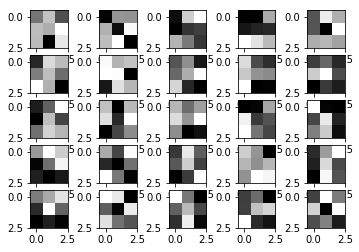

In [20]:
# Weights before training
x1w = x.get_weights()[0][:,:,0,:]
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

In [35]:
# Train weights
if not os.path.isfile("model.h5"):
    
    csv_logger = CSVLogger('history.csv', 
                               separator=',', 
                               append=False)
    model.fit(train_images, train_labels,
              batch_size=32,
              epochs=2,
              validation_data=(test_images, test_labels),
              shuffle=True,
              callbacks=[early_stopping, csv_logger])
    # serialize weights to HDF5
    model.save_weights("model.h5")
    history = model.history.history
    
    print("Saved model to disk")
else:
    model.load_weights("model.h5")
    log_data = pd.read_csv('history.csv', 
                               sep=',', 
                               engine='python')
    history = log_data
    print("Loaded model from disk")

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 35s 708us/step - loss: 0.7305 - acc: 0.7516 - val_loss: 0.7203 - val_acc: 0.7555
Epoch 2/2
50000/50000 [==============================] - 37s 734us/step - loss: 0.7185 - acc: 0.7556 - val_loss: 0.7224 - val_acc: 0.7618
Saved model to disk


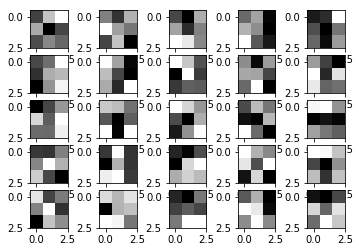

In [6]:
# Weights after training
x1w = x.get_weights()[0][:,:,0,:]
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

In [32]:
# evaluate loaded model on test data
model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = model.evaluate(train_images, train_labels, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print(model.summary())

acc: 79.71%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_10 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        18496    

In [ ]:
# Plot of the model (Windows only)
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

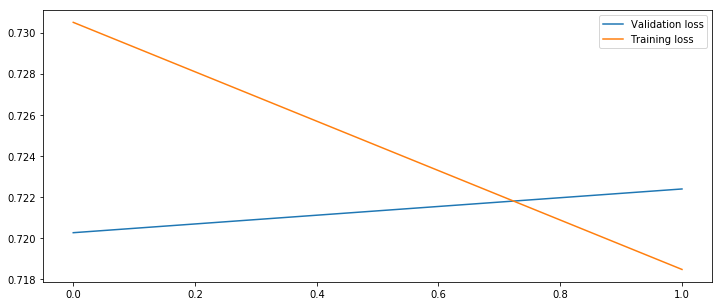

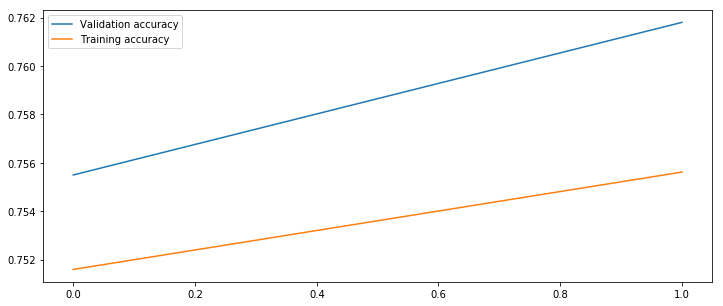

10000/10000 [==============================] - 3s 341us/step
The final loss on the test set is: 0.7223851396560669
The final accuracy on the test set is: 0.7618


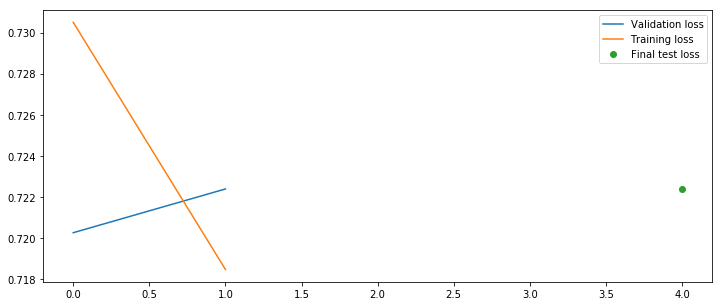

In [37]:
''' Visulize loss and acurracy for a network '''
# plot losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.legend()
plt.show()

# plot accuracy
plt.figure(figsize=(12, 5))
plt.plot(history['val_acc'], label='Validation accuracy')
plt.plot(history['acc'], label='Training accuracy')
plt.legend()
plt.show()

final_loss, final_accuracy = model.evaluate(test_images, test_labels)
print('The final loss on the test set is:', final_loss)
print('The final accuracy on the test set is:', final_accuracy)

# plot final losses
plt.figure(figsize=(12, 5))
plt.plot(history['val_loss'], label='Validation loss')
plt.plot(history['loss'], label='Training loss')
plt.plot([5-1], [final_loss], 'o', label='Final test loss')
plt.legend()
plt.show()
